<a href="https://colab.research.google.com/github/IphixLi/Fastai-deep-learning/blob/main/Lesson03_nn_foundations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
Mounted at /content/gdrive


In [28]:
#hide
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *

We will be doing Digit clssifier. so use famous MNIST dataset. we will focus on just 3s and 7s

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid')]

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

we are using the Image class from the Python Imaging Library (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

BAsically , an Image is a vector matrix of numbers. We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [ ]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:22,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Baseline model

We will create a baseline model. we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the “ideal” 3 and 7.

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

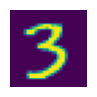

In [ ]:
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called stack that we can use for this purpose.

In [20]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [21]:
len(stacked_threes.shape)
# stacked_threes.ndim   //another way to get rank

3

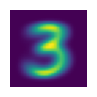

In [22]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

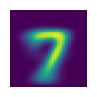

In [23]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's now pick an arbitrary 3 and measure its distance from our “ideal digits.”  

How can we determine its distance from our ideal 3? We can’t just add up the differences between the pixels of this image and the ideal digit.

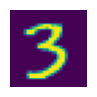

In [24]:
a_3 = stacked_threes[1]
show_image(a_3);

In [25]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [26]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

You can see that the difference between 7 vs ideal 3 is larger than 3 vs ideal 3.

PyTorch already provides both of these as loss functions. You’ll find these inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

 Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).


In [27]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

tensor numpy primer

In [29]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [32]:
tns[:,1]  # get column slice.

tensor([2, 5])

## Metrics Using Broadcasting

So to start with, let’s create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

In [33]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [34]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [35]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

In [36]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [37]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [38]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [39]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [40]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)
Here we are assuming that x is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector w. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

In [41]:
def pr_eight(x,w): return (x*w).sum()

## Steps for Machine learning classifier

1.   Initialize the weights.
2. For each image, use these weights to predict whether it appears to be a 3 or a 7.
3. Based on these predictions, calculate how good the model is (its loss).
4. Calculate the gradient, which measures for each weight, how changing that weight would change the loss
5. Step (that is, change) all the weights based on that calculation.
6. Go back to the step 2, and repeat the process.
7. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don’t want to wait any longer).



In [43]:
def f(x): return x**2

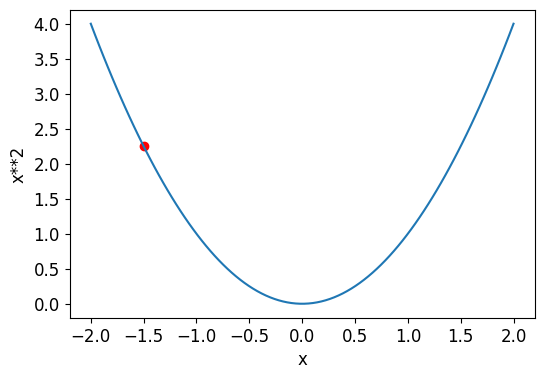

In [45]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

Notice the special method requires_grad_? That’s the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.

In [51]:
xt = tensor(3.).requires_grad_()

In [52]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [53]:
# calculate gradient
yt.backward()  # really calculating gradient, fancy vocab though

xt.grad # now see gradient

tensor(6.)

In [54]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [55]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [56]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

## stepping gradient

we subtract the gradient * lr from the parameter to update it. This allows us to adjust the parameter in the direction of the slope by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive.

` w -= gradient(w) * lr `

## END TO END SGD exaple

In [58]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

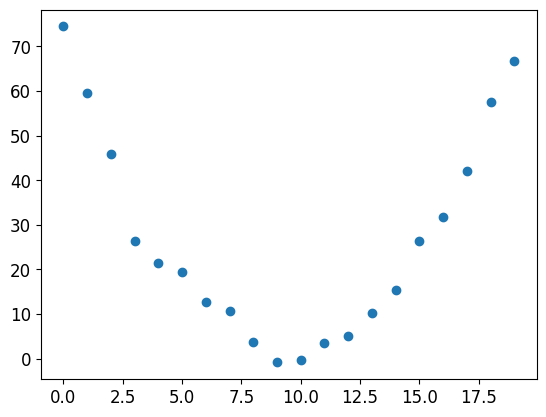

In [59]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [60]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [61]:
def mse(preds, targets): return ((preds-targets)**2).mean()

In [63]:
# Initialize parameters
params = torch.randn(3).requires_grad_()

# calculate predictions
preds = f(time, params)

In [64]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

In [65]:
loss = mse(preds, speed)
loss

tensor(8631.7373, grad_fn=<MeanBackward0>)

In [66]:
loss.backward()
params.grad

tensor([29901.0918,  1916.4382,   111.7121])

In [67]:
params.grad * 1e-5

tensor([0.2990, 0.0192, 0.0011])

## MNIST Loss Function


In [69]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [70]:
# add labels
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [71]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [72]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))